In [70]:
import numpy as np 
import pandas as pd 
import os, sys, re, csv, codecs
import matplotlib.pyplot as plt 

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix

In [71]:
batch_size = 64
epochs = 10

train = pd.read_csv('train/train.csv', encoding = 'ascii', encoding_errors='backslashreplace')
test = pd.read_csv('test/test.csv', encoding = 'ascii', encoding_errors='backslashreplace')

In [72]:
classifications = ["Toxic", "Extremely Toxic", "Obscene", "Threat", "Insult", "Identity Hate"]
Y = train[classifications].values

train_sentences = train["comment_text"]
test_sentences = test["comment_text"]

In [73]:
#we will feed the comments into an LSTM (Long Short Term Memory) network. There are some steps we need to do:
#1. Tokenization - turn each sentence into a list of words 
#2. Indexing - index each word in a dictionary 
#3. Index Representation - Feed the indexed representations to the LSTM 

max_indexes = 25000
tokenizer = Tokenizer(num_words=max_indexes)
tokenizer.fit_on_texts(list(train_sentences))
tokenized_train = tokenizer.texts_to_sequences(train_sentences)
tokenized_test = tokenizer.texts_to_sequences(test_sentences)

In [74]:
#add padding to limit any abnormally long sentences, effectively saving memory and time at a small cost of model accuracy 

max_length = 150
X_train = pad_sequences(tokenized_train, maxlen=max_length)
X_test = pad_sequences(tokenized_test, maxlen=max_length)

In [75]:
#Input layer
inpt = Input(shape = (max_length, ))

#Embedding layer - list of coordinates to words in vector space
embed_size = 200
X = Embedding(max_length, embed_size)(inpt)

#LSTM layer 
X = LSTM(batch_size, return_sequences=True, name='LSTM_Layer')(X) 

#Pooling to reshape 3D tensor to 2D
X = GlobalMaxPool1D()(X)
X = Dropout(0.1)(X)
X = Dense(50)(X)
X = Activation('relu')(X)
X = Dropout(0.1)(X)
X = Dense(6)(X)
X = Activation('sigmoid')(X)

#Define inputs, outputs and configure learning process
model = Model(inputs=inpt, outputs=X)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 150, 200)          30000     
                                                                 
 LSTM_Layer (LSTM)           (None, 150, 64)           67840     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                3250      
                                                           

In [76]:
history = model.fit(X_train, Y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.save('updated_ccc.h5')

um_classes = 6

#model = load_model('updated_ccc.h5')
results = model.predict([X_test], batch_size=batch_size, verbose = 1)

test_results = pd.read_csv('results.csv')
test_results[classifications] = results
test_results.to_csv('results.csv', index=False)


Epoch 1/10
2244/2244 [==============================] - 28s 12ms/step - loss: 0.1114 - accuracy: 0.9295 - val_loss: 0.0946 - val_accuracy: 0.9940
Epoch 2/10
2244/2244 [==============================] - 25s 11ms/step - loss: 0.0918 - accuracy: 0.9899 - val_loss: 0.0899 - val_accuracy: 0.9940
Epoch 3/10
2244/2244 [==============================] - 25s 11ms/step - loss: 0.0896 - accuracy: 0.9934 - val_loss: 0.0899 - val_accuracy: 0.9940
Epoch 4/10
2244/2244 [==============================] - 25s 11ms/step - loss: 0.0879 - accuracy: 0.9941 - val_loss: 0.0890 - val_accuracy: 0.9940
Epoch 5/10
2244/2244 [==============================] - 25s 11ms/step - loss: 0.0865 - accuracy: 0.9942 - val_loss: 0.0877 - val_accuracy: 0.9940
Epoch 6/10
2244/2244 [==============================] - 25s 11ms/step - loss: 0.0855 - accuracy: 0.9941 - val_loss: 0.0874 - val_accuracy: 0.9940
Epoch 7/10
2244/2244 [==============================] - 26s 11ms/step - loss: 0.0843 - accuracy: 0.9942 - val_loss: 0.0870 -

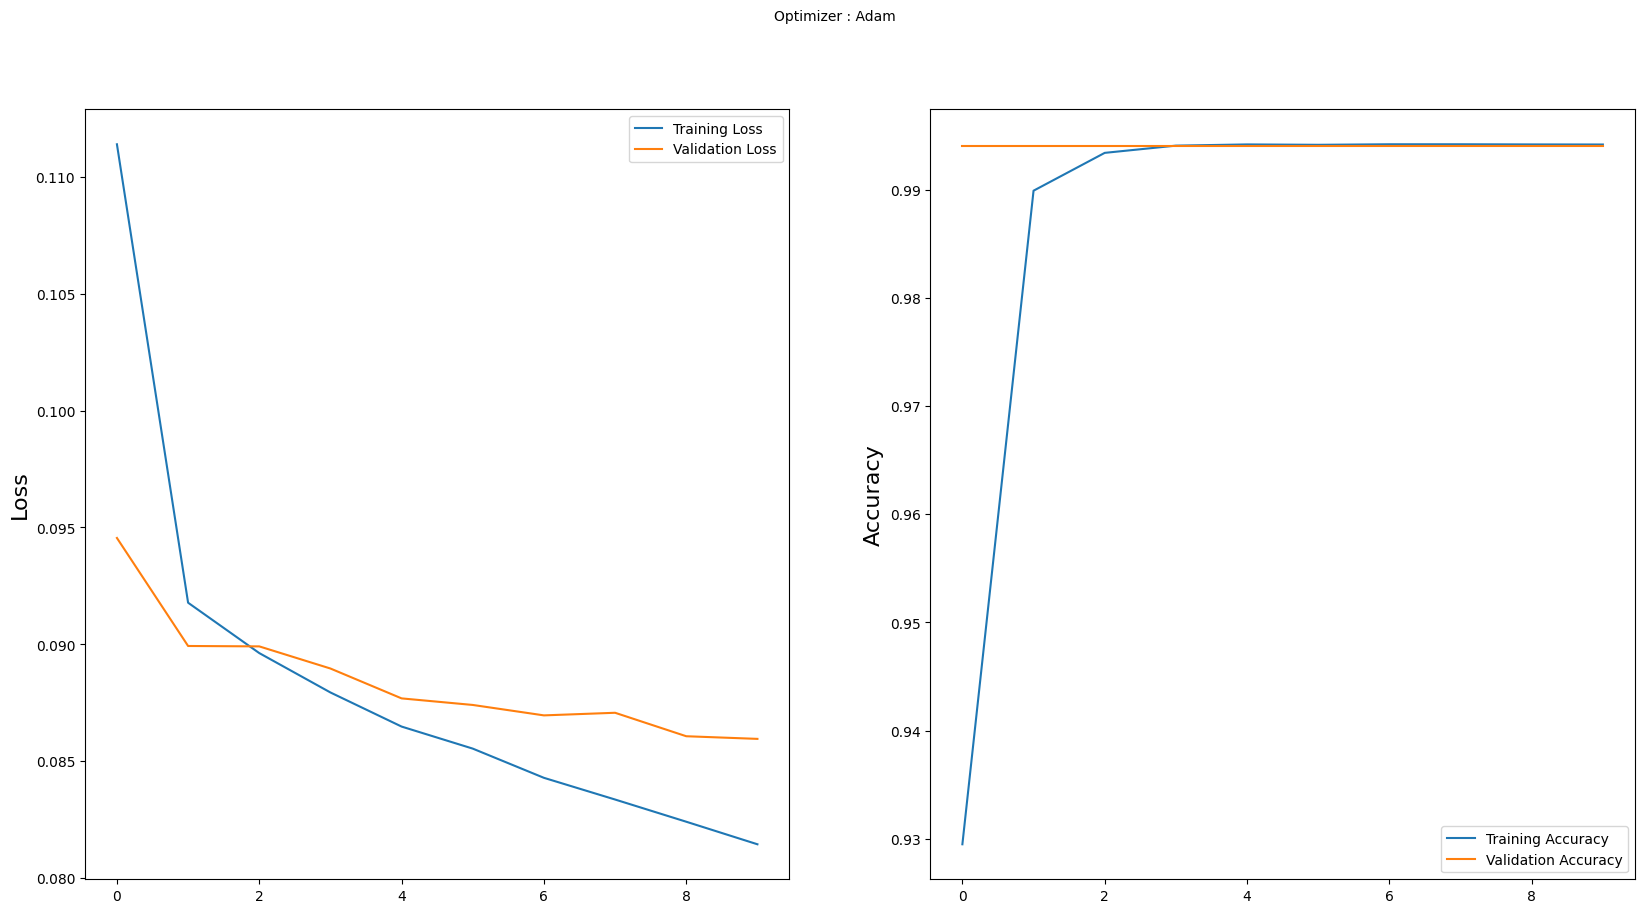

In [77]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [78]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

In [79]:
#CURRENTLY BROKEN

# # compute confusion matrix
# matrix = confusion_matrix(test_results, y_pred)
# np.set_printoptions(precision = 2)
# # plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(matrix, classes=classifications, title='Normalized Confusion Matrix')
# plt.show()